# Standardization and PCA

### Standardize the Imputed Data and apply PCA

In [1]:
import pandas as pd
import numpy as np

#%matplotlib notebook to make interactive within same window as JN
#%matplotlib
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

#SciKit Learn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.decomposition import PCA

#Plotly
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
import scipy as sci
import statsmodels as stats

from impyute.imputation.cs import mice
from collections import Counter

import warnings  
#Suppression of warnings (if not completed earlier):
#ignore permanently:
#warnings.filterwarnings('ignore')
#reset wanrnings:
#warnings.resetwarnings()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

#######################
###  Entire Process ###
#######################
WorldData = pd.read_csv("WorldMarketData.csv", na_values = '..')
df_original = pd.DataFrame(WorldData)
df_original.columns = ['country', 'country_code', 'series', 'series_code', '1994', '1995', '1996', '1997', '1998', 
             '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', 
             '2012', '2013', '2014', '2015', '2016', '2017', '2018']

df = df_original.drop(columns=['country_code', 'series_code'])
df = df.drop(df.index[3800:])
df1 = pd.melt(df,["country", 'series'],var_name="year",value_name="value")
#df1 = df1.sort_values(by=["year"], ascending = True)
df1 = df1.set_index('country').drop(index = ['World', 'Low income', 'Middle income', 'High income'])
df1 = df1.reset_index()
df1['year'] = df1['year'].astype(int)
df1.head()

df_stack = df1.set_index(['series', 'country'])
df_stack_all = df_stack
dfsa = df_stack_all.reset_index()
dfsa = dfsa.pivot_table(index = ['country', 'year'], columns = 'series', values='value', dropna=False)
dfsa = dfsa.reset_index()
#Filter the series that have less than 1000 entries
dfsa = dfsa.dropna(thresh=len(dfsa) - 1000, axis=1)
dfsa.head()

#Reshape
df2 = pd.melt(dfsa,["country", 'year'],var_name="series",value_name="value")
df2 = df2.pivot_table(index = ['country','series'], columns = 'year', values='value', dropna = False)

#Filter
m = df2.notna().sum(1).groupby(level=1).transform(lambda x: x.ge(1).all())
df2 = df2[m]
#Reset Shape
df2 = df2.reset_index()
df2 = pd.melt(df2,["country", 'series'],var_name="year",value_name="value")
df2.head(5)
#Set 'year' to Float so that `mice` can be applied
df2['year'] = df2['year'].astype(float)

#Group df2 by country-series pairs
dfgrp = df2.groupby(['country', 'series']) 

#Create a blank dataframe for the imputed data
ImpData = pd.DataFrame([])

#call the group in a for loop
for dfgrp_index, group in dfgrp:

        #if any values within the group are null then proceed
        if group.isnull().values.any() == True:
            
            #Apply the imputation to the group's values
            group['value'] = ((mice(group.apply({'year': lambda x: x.values, 'value': lambda y: y.values})))[1]).values
            
            #Append the imputed group to the ImpData dataframe
            ImpData = ImpData.append(pd.DataFrame({'country': group.country.values, 'series': group.series.values, 'year': group.year.values, 'value': group.value.values}))
                
        #if no values in the group are null then append the groups values to the ImpData dataframe        
        else:
            
            #d = d.append(pd.DataFrame({'A': group.A.values, 'B': group.B.values, 'C': group.C.values, 'D': group.D.values}))
            ImpData = ImpData.append(pd.DataFrame({'country': group.country.values, 'series': group.series.values, 'year': group.year.values, 'value': group.value.values}))
            
            #Advance to the next group
            continue

#Reset the index of the dataframe after everything has been filled
ImpData = ImpData.reset_index()
#drop the created 'index' column (these two steps are unnecessary, but resetting the index is just a precaution)
ImpData = ImpData.drop(columns = ['index'])

#Change years back to Int from Float64 for readability
ImpData['year'] = ImpData['year'].astype(int)
#Display the total null values within the dataframe (should be 0)
ImpData.isnull().sum().sum() 
#Copy to new df for easier access
imp_df = ImpData.copy()
imp_df.head()

country                                             series  year  value
0  Argentina  Cost of business start-up procedures (% of GNI...  1994  20.39
1  Argentina  Cost of business start-up procedures (% of GNI...  1995  20.05
2  Argentina  Cost of business start-up procedures (% of GNI...  1996  19.71
3  Argentina  Cost of business start-up procedures (% of GNI...  1997  19.38
4  Argentina  Cost of business start-up procedures (% of GNI...  1998  19.04

In [41]:
imp_df.head()

country                                             series  year  value
0  Argentina  Cost of business start-up procedures (% of GNI...  1994  20.39
1  Argentina  Cost of business start-up procedures (% of GNI...  1995  20.05
2  Argentina  Cost of business start-up procedures (% of GNI...  1996  19.71
3  Argentina  Cost of business start-up procedures (% of GNI...  1997  19.38
4  Argentina  Cost of business start-up procedures (% of GNI...  1998  19.04

In [42]:
series_pivoted = imp_df.pivot_table(index = ['country', 'year'], columns = 'series', values= 'value')
series_pivoted.head(3)

series          Cost of business start-up procedures (% of GNI per capita)  \
country   year                                                               
Argentina 1994                                              20.39            
          1995                                              20.05            
          1996                                              19.71            

series          Cost to export, border compliance (US$)  \
country   year                                            
Argentina 1994                                   150.00   
          1995                                   150.00   
          1996                                   150.00   

series          Cost to export, documentary compliance (US$)  \
country   year                                                 
Argentina 1994                                         60.00   
          1995                                         60.00   
          1996                                         60.00   

series          Cost to import, border compliance (US$)  \
country   year                                            
Argentina 1994                                 1,200.00   
          1995                                 1,200.00   
          1996                                 1,200.00   

series          Cost to import, documentary compliance (US$)  \
country   year                                                 
Argentina 1994                                        120.00   
          1995                                        120.00   
          1996                                        120.00   

series          Export value index (2000 = 100)  \
country   year                                    
Argentina 1994                            60.13   
          1995                            79.58   
          1996                            90.39   

series          Exports of goods and services (% of GDP)  \
country   year                                             
Argentina 1994                                      7.53   
          1995                                      9.68   
          1996                                     10.43   

series          Exports of goods and services (current US$)  \
country   year                                                
Argentina 1994                            19,385,100,000.00   
          1995                            24,978,532,000.00   
          1996                            28,381,400,000.00   

series          External balance on goods and services (current US$)  \
country   year                                                         
Argentina 1994                                  -7,914,860,000.00      
          1995                                  -1,059,485,000.00      
          1996                                  -1,767,000,000.00      

series          GDP (current US$)  ...  \
country   year                     ...   
Argentina 1994 257,440,000,000.00  ...   
          1995 258,031,750,000.00  ...   
          1996 272,149,750,000.00  ...   

series          Start-up procedures to register a business (number)  \
country   year                                                        
Argentina 1994                                              13.26     
          1995                                              13.27     
          1996                                              13.29     

series          Tariff rate, applied, simple mean, all products (%)  \
country   year                                                        
Argentina 1994                                              14.58     
          1995                                              12.70     
          1996                                              14.45     

series          Tariff rate, most favored nation, weighted mean, all products (%)  \
country   year                                                                      
Argentina 1994                                  

In [53]:
#StadardScaler is less effective in this case, and later would require more principal components
min_max_scaler = preprocessing.MinMaxScaler()

#Get unscaled values in an array from the unscaled df with the series pivoted
unscaled_values_array = series_pivoted.values

#The scaled values
scaled_values = min_max_scaler.fit_transform(unscaled_values_array)
x = scaled_values

#A dataframe visualization of the scaling on the series_pivoted
scaled_pivot_df = pd.DataFrame(scaled_values, columns = series_pivoted.columns, index = series_pivoted.index)

In [71]:
#Set the model criteria for the PCA
#Best practices is 85%-95% but we want to minimize the principal components as much as possible
#Whatever number of principal components where 75% of variance is retained
pca_model = PCA(.75)

#Get an array of the PCA values
pca_values = pca_model.fit_transform(scaled_values)

#Show number of components
print('Number of principal components:')
print(pca_model.n_components_)

#Show how much variance is explained with each PC
print('Variance explained with each PC:')
print(pca_model.explained_variance_ratio_)

#Show values array
print('PCA array values:')
print(pca_values)

Number of principal components:
6
Variance explained with each PC:
[0.40463016 0.12714877 0.0973351  0.06617946 0.04867599 0.03385499]
PCA array values:
[[ 0.41515204  0.18527746 -0.00977374 -0.45162453 -0.05342213  0.33430201]
 [ 0.38779268  0.18009886 -0.01130368 -0.44094412 -0.12298108  0.25875572]
 [ 0.41010554  0.17074282 -0.01715492 -0.42681268 -0.04403387  0.31205479]
 ...
 [ 1.0243956  -0.09272687 -0.1122392   0.16571108 -0.11434468  0.10401213]
 [ 0.90369726 -0.08608846 -0.10413921  0.1794263  -0.11568044  0.0815043 ]
 [ 0.89687314 -0.11293076 -0.12700146  0.24437263 -0.10204664  0.10686364]]


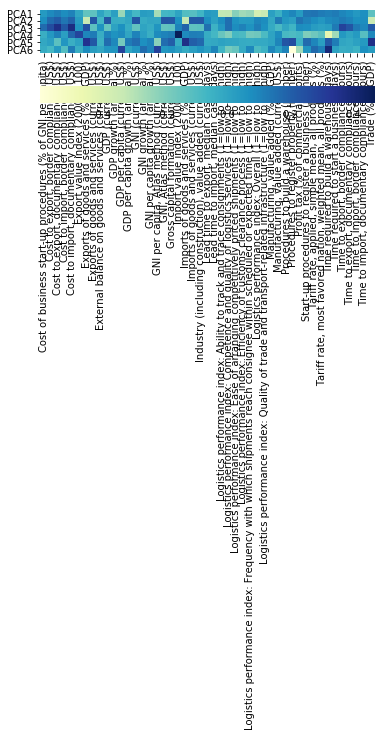

In [68]:
x = pd.DataFrame(x, columns=series_pivoted.columns)


ax = sns.heatmap(pca_model.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca_model.n_components_+1)],
                 xticklabels=list(x.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

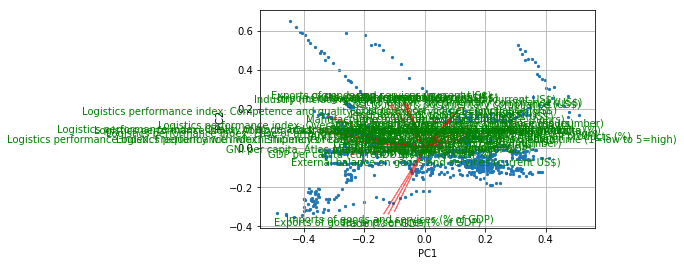

In [70]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

myplot(pca_values[:,0:2],np.transpose(pca_model.components_[0:2, :]),list(x.columns))
plt.show()

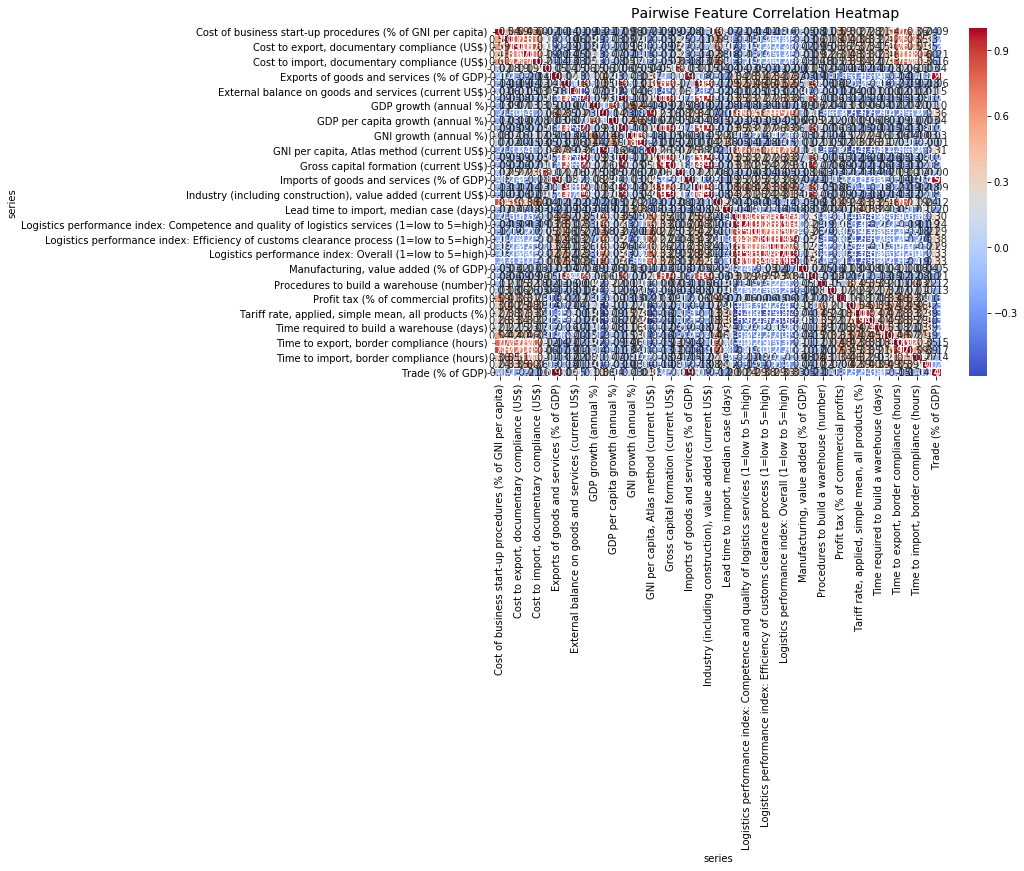

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
corr = scaled_pivot_df.corr()
heat_map = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
fig.subplots_adjust(top=0.93)
t= fig.suptitle('Pairwise Feature Correlation Heatmap', fontsize=14)

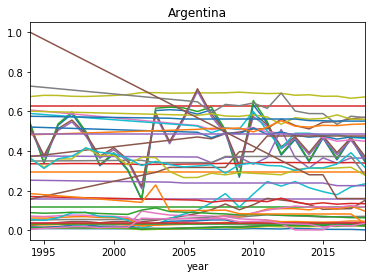

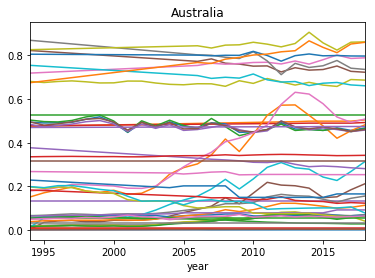

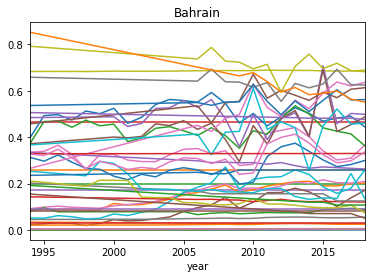

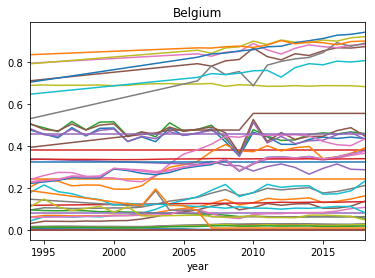

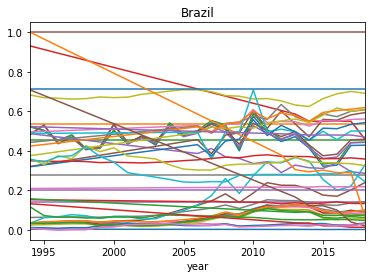

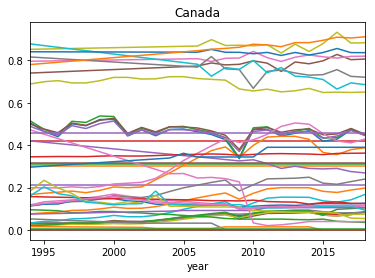

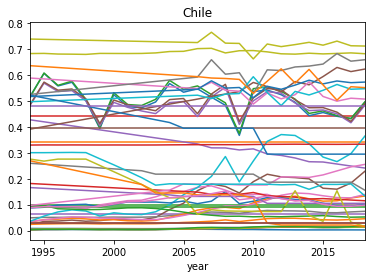

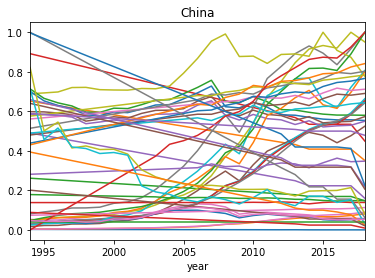

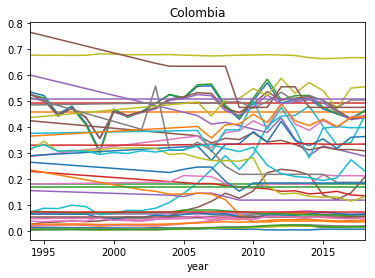

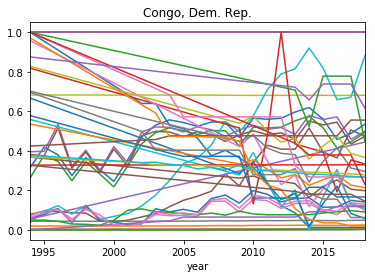

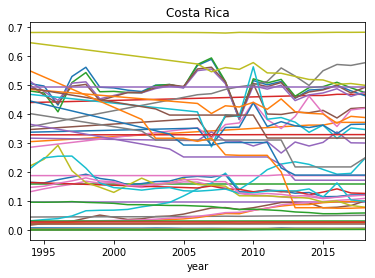

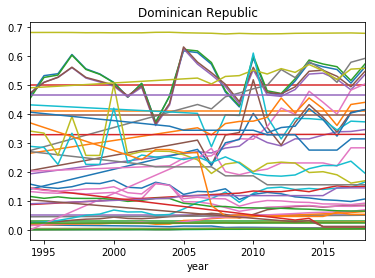

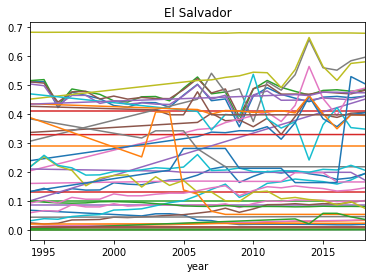

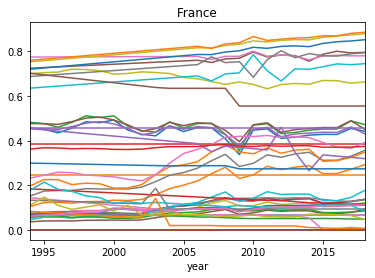

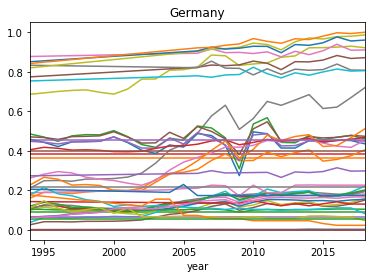

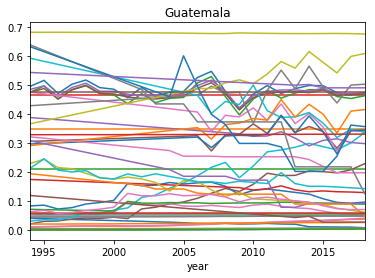

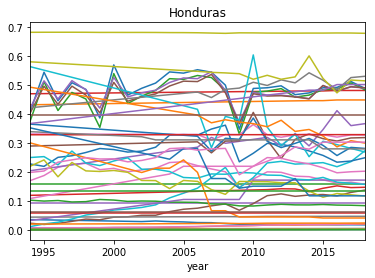

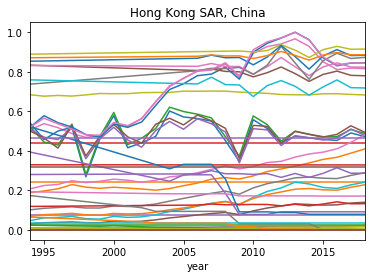

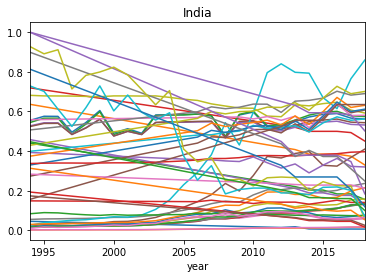

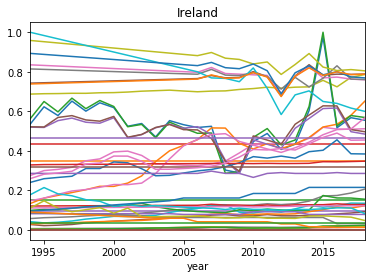

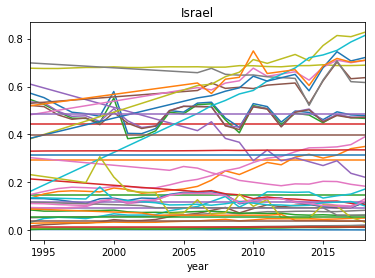

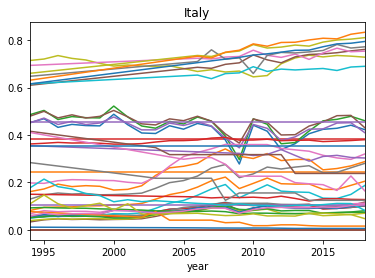

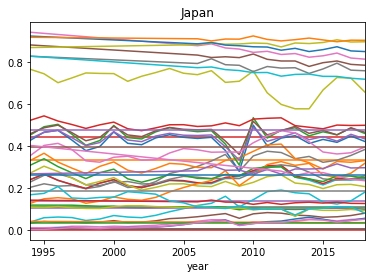

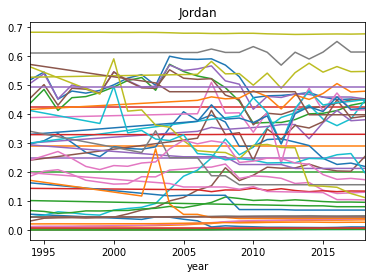

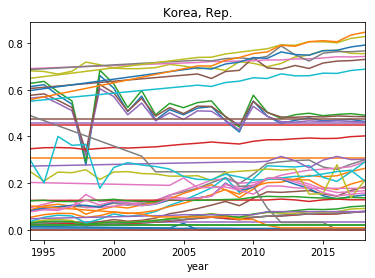

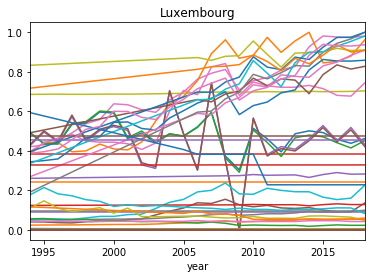

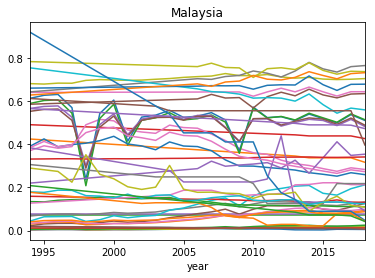

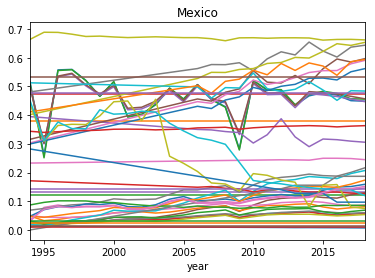

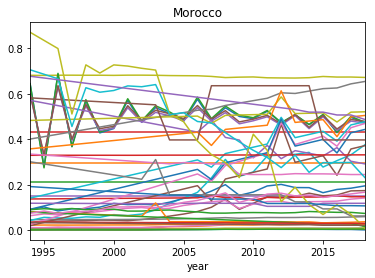

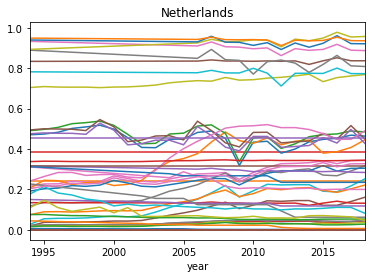

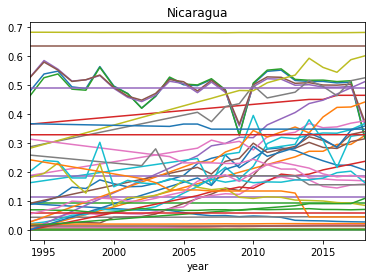

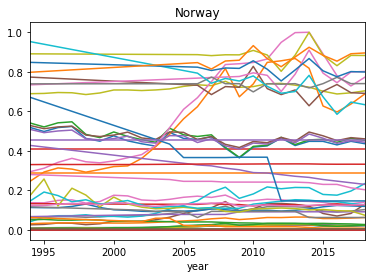

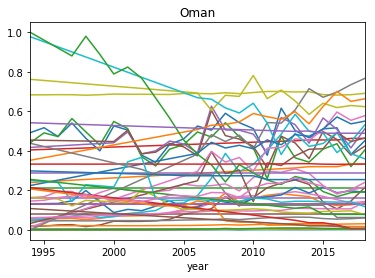

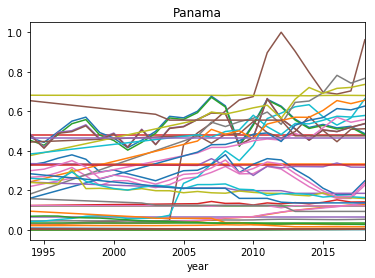

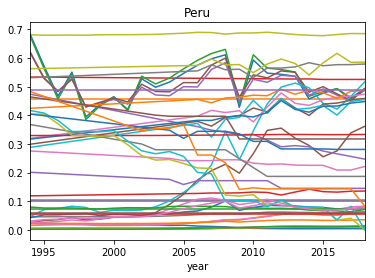

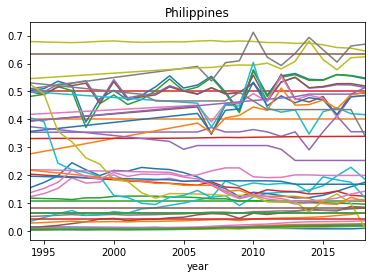

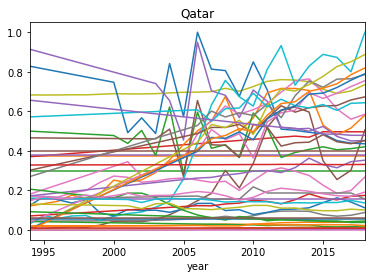

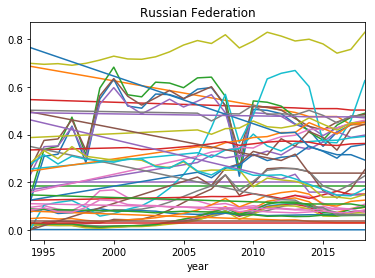

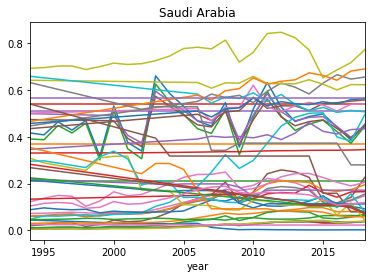

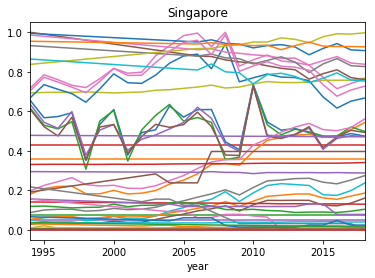

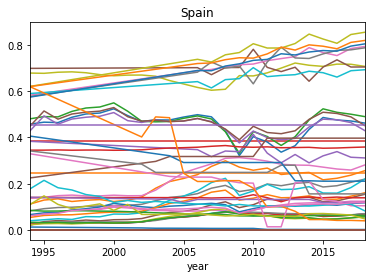

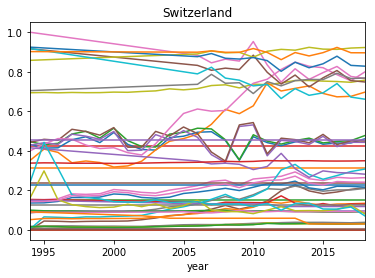

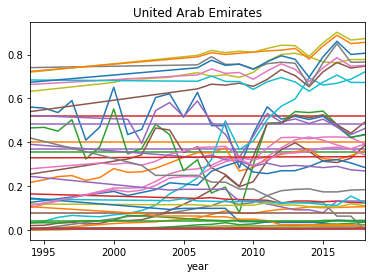

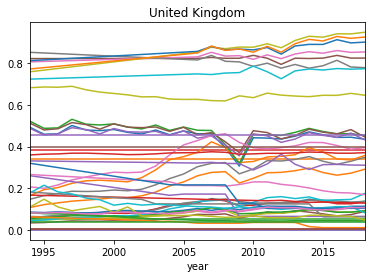

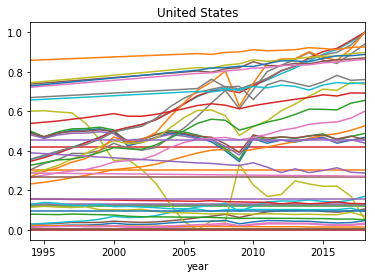

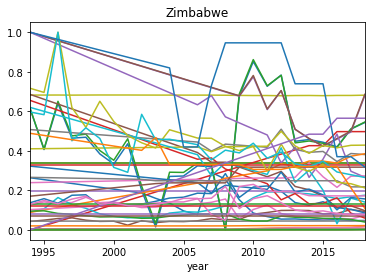

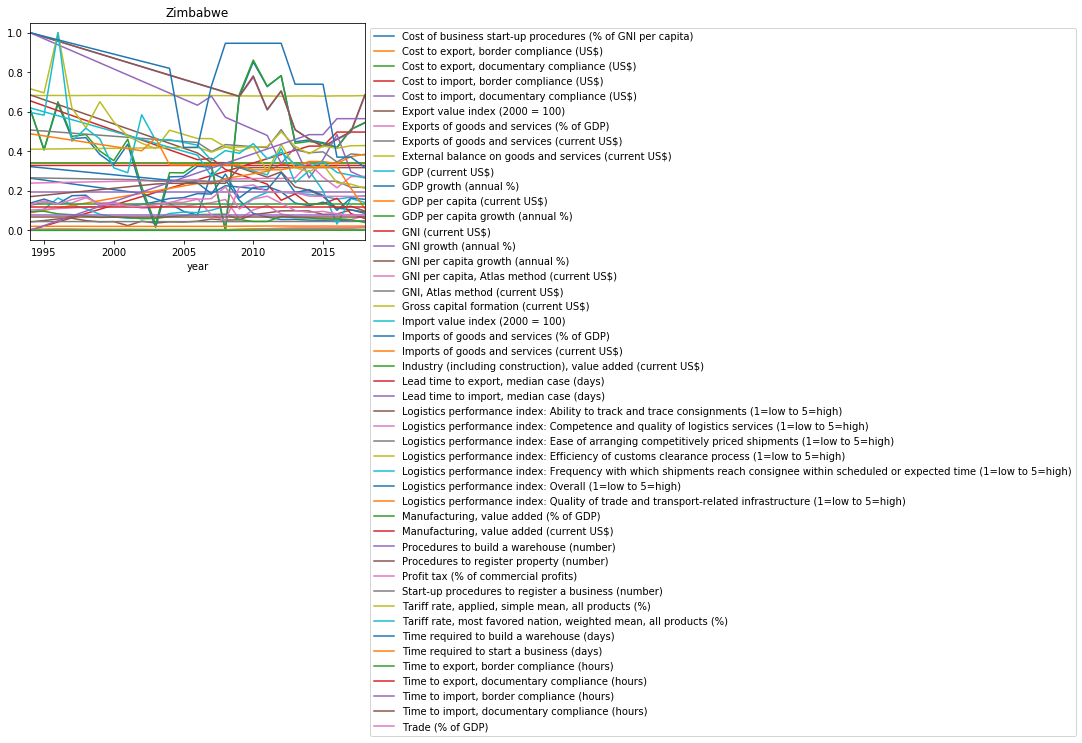

In [72]:
grouped_countries = scaled_pivot_df.reset_index().groupby(['country'])

#Do one group with the legend, and use the .legend to have it on the outside righthand side.
#group.plot(x = 'year', title = group_name).legend(bbox_to_anchor=(1,1))

#Graph the remaining groups without the legend

for group_name, group in grouped_countries:
    
    #Hid the legend so that everything would be easier to see
    group.plot(x = 'year', title = group_name, legend = False)
    
    
#Do one group with the legend, and use the .legend to have it on the outside righthand side.
group.plot(x = 'year', title = group_name).legend(bbox_to_anchor=(1,1)) 